In [55]:
import pandas as pd
from numpy import mean
from numpy import median
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns


from warnings import catch_warnings
from warnings import filterwarnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from multiprocess import cpu_count
from joblib import Parallel

from joblib import delayed

In [56]:
## Funcion utilidad
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

# validación "walk-forward" para datos univariados
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        ejecutor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
        resultados = ejecutor(tareas)
    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    print(len(resultados))
    return resultados



def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

#
#  Prediccion promedio (simple)
#

def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])


#
#  Prediccion SARIMA
#


def config_sarima():
    modelos = []
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    P_params = [0, 1]
    D_params = [0, 1]
    Q_params = [0, 1]
    m_params = [12]  # Assuming monthly data
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p, d, q), (P, D, Q, m), 'n']
                                modelos.append(cfg)
    return modelos

def prediccion_sarima(historia, config):
    orden, orden_estacional, _ = config
    modelo = SARIMAX(historia, order=orden, seasonal_order=orden_estacional,
                     enforce_stationarity=False, enforce_invertibility=False, maxiter=20)
    modelo_ajustado = modelo.fit(disp=False)
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]



#
#  Alizamiento exponencial - Holt-Winters
#

def prediccion_alisamiento_exp(historia, config):
    t, d, s, p, b, r = config
    # definir el modelo
    historia = array(historia)
    modelo = ExponentialSmoothing(historia, trend = t, damped_trend = d, seasonal = s, 
                                  seasonal_periods = p)
    # ajustar el modelo con los datos
    modelo_ajustado = modelo.fit(optimized = True, remove_bias = r)
    # predecir un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_alisamiento_exp(estacional = [2]): 
    modelos = []
    # definir las listas de config
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = estacional
    b_params = [True, False]
    r_params = [True, False]
    # crear instancias de configuración
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            modelos.append(cfg)
    return modelos

## Exploratory Data Analysis

In [57]:

df = pd.read_csv('monthly-mean-temp.csv')
df.head()


,Month,Temperature
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


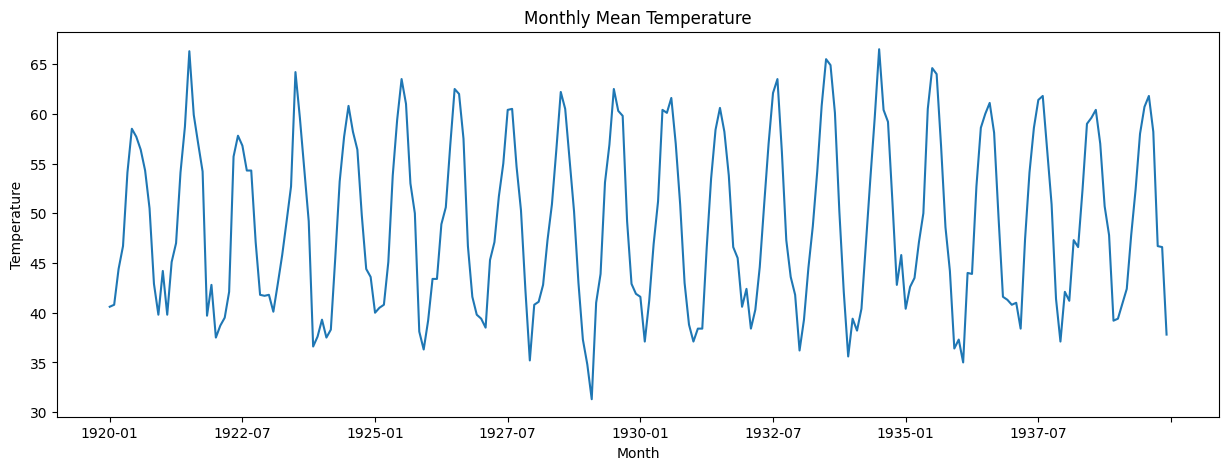

In [58]:

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['Month'], df['Temperature'])
ax.set_xlabel('Month')
ax.set_ylabel('Temperature')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_title('Monthly Mean Temperature')
plt.show()


In [59]:

print(df.describe())


       Temperature
count   240.000000
mean     49.041250
std       8.569705
min      31.300000
25%      41.550000
50%      47.350000
75%      57.000000
max      66.500000


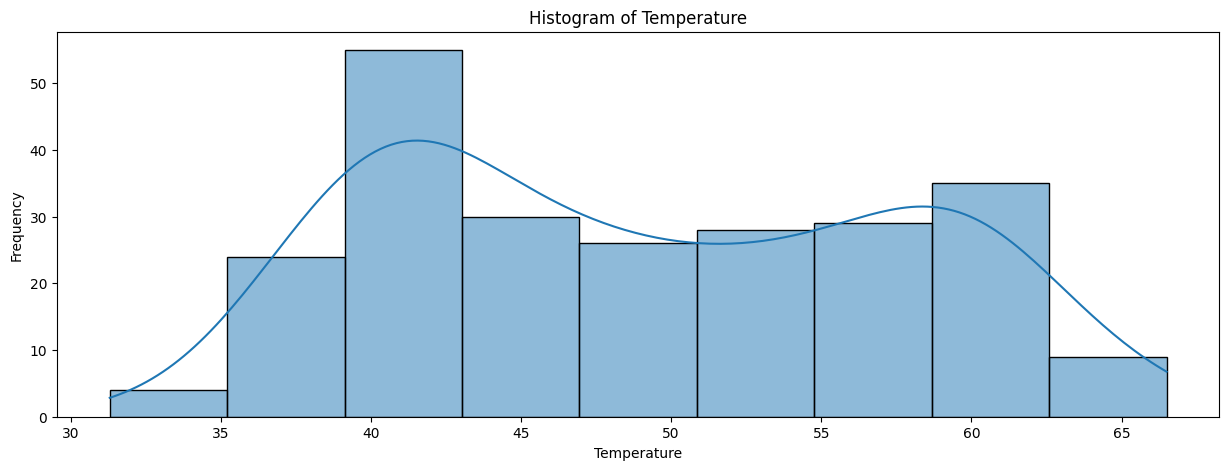

In [73]:
plt.figure(figsize=(15, 5))
sns.histplot(df['Temperature'], kde=True)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature')
plt.show()


## Promedios

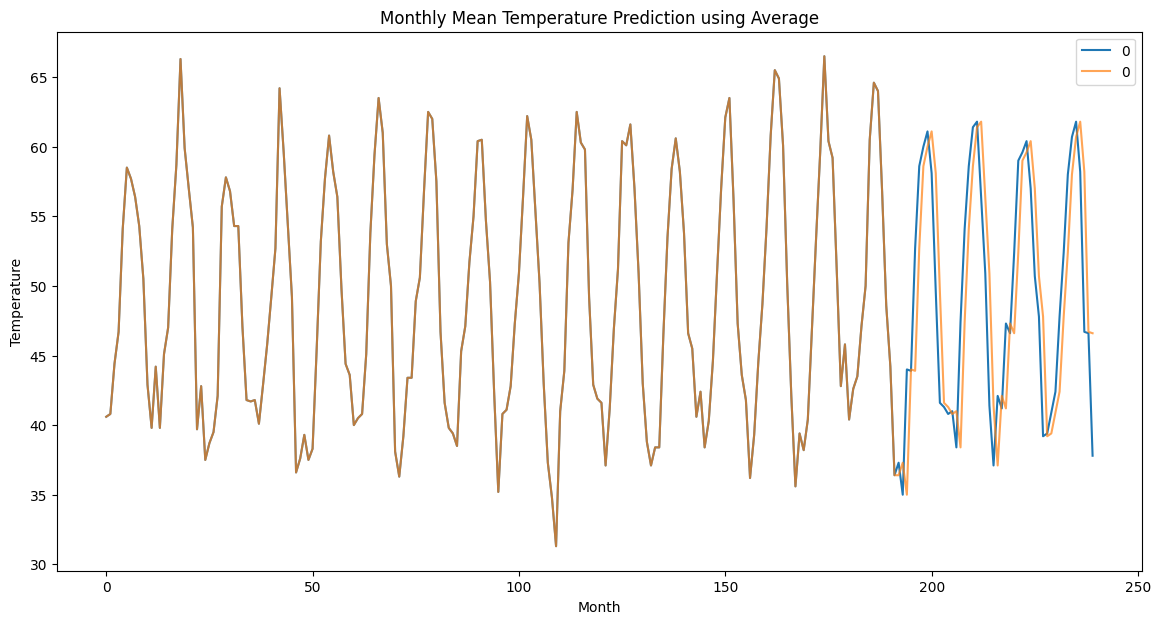

MSE: 5.143604443060009


In [60]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from numpy import mean, median

# Load the dataset
series_temp = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=0)
datos_temp = series_temp.values
n_prueba_temp = int(len(datos_temp) * 0.2)  # using 20% for testing
long_max_temp = len(datos_temp) - n_prueba_temp
cfg_temp = config_simple(long_max_temp)[1]
entreno_temp = datos_temp[:-n_prueba_temp]
prueba_temp = datos_temp[-n_prueba_temp:]
historia_temp = [x for x in entreno_temp]    
predicciones_temp = []

for i in range(len(prueba_temp)):
    yhat_temp = prediccion_promedio(historia_temp, cfg_temp)
    predicciones_temp.append(yhat_temp)
    historia_temp.append(prueba_temp[i])

error_temp = sqrt(mean_squared_error(prueba_temp, predicciones_temp))

# Plot
prediccion_temp = pd.DataFrame(list(entreno_temp.flatten()) + predicciones_temp)
ax_temp = pd.DataFrame(datos_temp).plot(label="Original")  # Original data
plt.title('Monthly Mean Temperature Prediction using Average')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
prediccion_temp.plot(ax=ax_temp, alpha=.7, figsize=(14,7))
plt.show()

print("MSE:", error_temp)


## SARIMA

In [61]:
datos_temp = series_temp.values
n_prueba_temp = int(len(datos_temp) * 0.2)
long_max_temp = len(datos_temp) - n_prueba_temp
lista_cfg_temp = config_sarima()
entreno_temp = datos_temp[:-n_prueba_temp]
prueba_temp = datos_temp[-n_prueba_temp:]
historia_temp = [x for x in entreno_temp]    
predicciones_temp = []

# Randomly sample 10 configurations
lista_cfg_temp = config_sarima()
predicciones_temp = []
for cfg in lista_cfg_temp:
    try:
        with catch_warnings():
            filterwarnings("ignore")
            yhat_temp = prediccion_sarima(historia_temp, cfg)
            predicciones_temp.append(yhat_temp)
    except:
        continue

# Ensure lengths match
if len(predicciones_temp) != len(prueba_temp):
    predicciones_temp = predicciones_temp[:len(prueba_temp)]

# Check for None values
if any([val is None for val in predicciones_temp]):
    print("Some predictions failed.")
else:
    error_temp = sqrt(mean_squared_error(prueba_temp, predicciones_temp))
    

MSE: 18.71250103162055


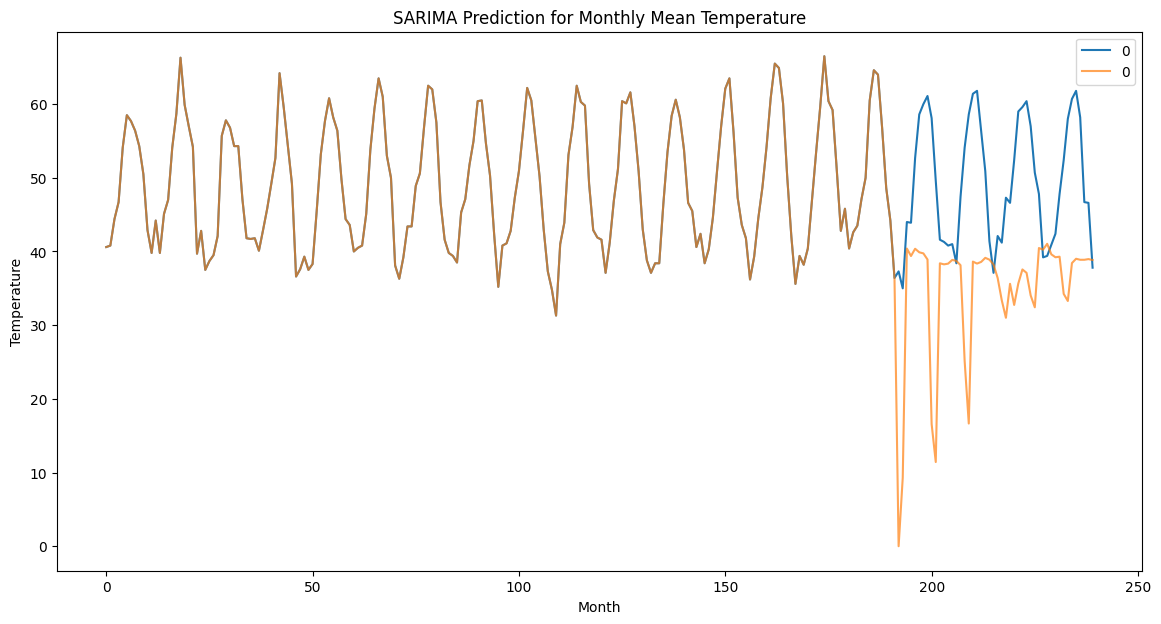

In [62]:
print("MSE:", error_temp)

prediccion_temp = pd.DataFrame(list(entreno_temp.flatten()) + predicciones_temp[:len(prueba_temp)])
ax_temp = pd.DataFrame(datos_temp).plot(label="Original", figsize=(14,7))  # Original data
plt.title('SARIMA Prediction for Monthly Mean Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
prediccion_temp.plot(ax=ax_temp, alpha=.7)

plt.show()

## Alisamiento exponencial

In [63]:
# Load the monthly-mean-temp dataset
series_temp = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=0)

datos_temp_exp = series_temp.values
n_prueba_temp_exp = 12  # Adjusted for a year's worth of data
long_max_temp_exp = len(datos_temp_exp) - n_prueba_temp_exp
lista_cfg_temp_exp = config_alisamiento_exp()
entreno_temp_exp = datos_temp_exp[:-n_prueba_temp_exp]
prueba_temp_exp = datos_temp_exp[-n_prueba_temp_exp:]
historia_temp_exp = [x for x in entreno_temp_exp]
predicciones_temp_exp = []

lista_cfg_temp_exp_sampled = random.sample(lista_cfg_temp_exp, k=3)
for cfg in lista_cfg_temp_exp_sampled:
    for i in range(len(prueba_temp_exp)):
        yhat_temp_exp = prediccion_alisamiento_exp(historia_temp_exp, cfg)
        predicciones_temp_exp.append(yhat_temp_exp)
        historia_temp_exp.append(prueba_temp_exp[i])

# Keep only the non-empty predictions
predicciones_temp_exp = [x for x in predicciones_temp_exp if x is not None]
error_temp_exp = sqrt(mean_squared_error(prueba_temp_exp, predicciones_temp_exp[0:n_prueba_temp_exp]))


MSE: 4.54994318369276


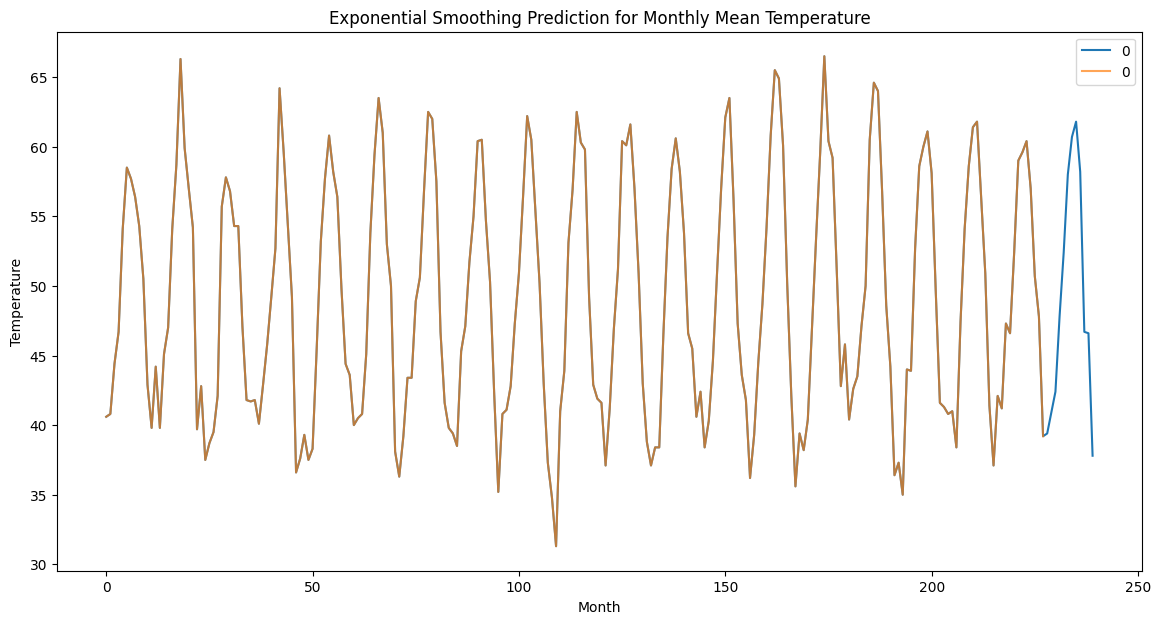

In [64]:
print("MSE:", error_temp_exp)

# Plotting
prediccion_temp_exp = pd.DataFrame(list(entreno_temp_exp.flatten()))
ax_temp_exp = pd.DataFrame(datos_temp_exp).plot(label="Original", figsize=(14,7))  # Original data
plt.title('Exponential Smoothing Prediction for Monthly Mean Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
prediccion_temp_exp.plot(ax=ax_temp_exp, alpha=.7)

plt.show()

## Prophet

In [65]:
from prophet import Prophet
prophet_series_temp = pd.read_csv("monthly-mean-temp.csv")
prophet_series_temp.columns = ['ds', 'y']
prophet_series_temp['ds'] = pd.to_datetime(prophet_series_temp['ds'])
prophet_series_temp.head()


,ds,y
0,1920-01-01,40.6
1,1920-02-01,40.8
2,1920-03-01,44.4
3,1920-04-01,46.7
4,1920-05-01,54.1


In [66]:
# Train the Prophet model
modelo_temp = Prophet(mcmc_samples=500, seasonality_mode='multiplicative')
modelo_ajustado_temp = modelo_temp.fit(prophet_series_temp)

# Make future predictions
futuro_temp = modelo_ajustado_temp.make_future_dataframe(periods=12, freq='M')
prediccion_temp = modelo_ajustado_temp.predict(futuro_temp)

23:45:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:45:44 - cmdstanpy - INFO - CmdStan done processing.
23:45:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if t

In [67]:
# Calculate MSE
error_temp_prophet = sqrt(mean_squared_error(prophet_series_temp['y'], prediccion_temp['yhat'][0:len(prophet_series_temp)]))
print("MSE:", error_temp_prophet)

MSE: 2.157491753673767


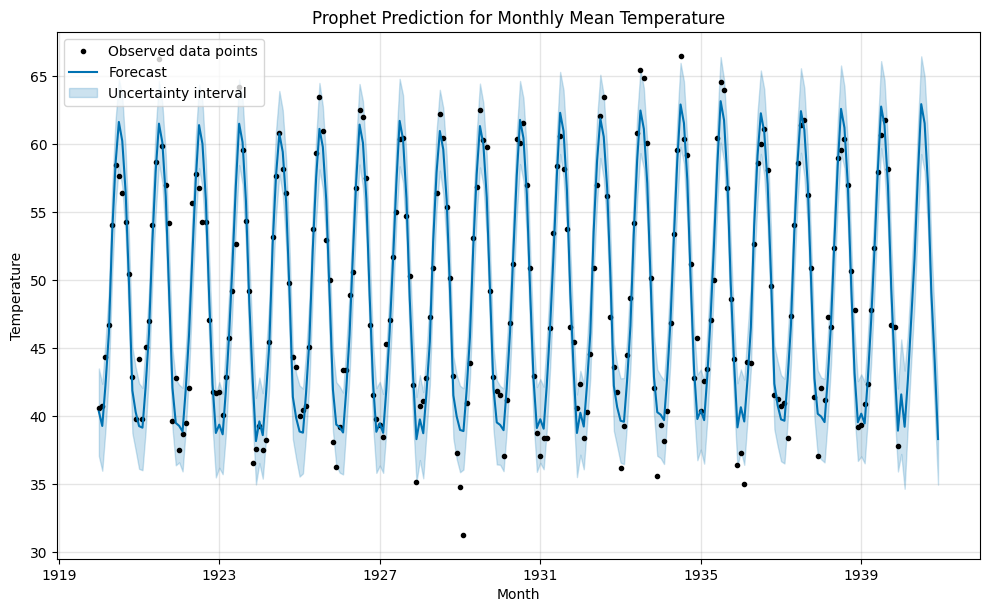

In [68]:
# Visualize the predictions
fig_temp = modelo_ajustado_temp.plot(prediccion_temp)
plt.title('Prophet Prediction for Monthly Mean Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend(loc='upper left')
plt.show()

## Redes Neuronales

In [69]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
# split a univariate dataset into train/test sets
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

def series_a_supervisado(datos, n_entrada, n_salida = 1):
	df = DataFrame(datos)
	cols = []
	# secuencia de entrada (t-n, ... t-1)
	for i in range(n_entrada, 0, -1):
		cols.append(df.shift(i))
	# secuencia predicha (t, t+1, ... t+n)
	for i in range(0, n_salida):
		cols.append(df.shift(-i))
	# juntarlo todo
	agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
	agg.dropna(inplace = True)
	return agg.values


def medir_rmse(actual, predicho):
	return sqrt(mean_squared_error(actual, predicho))


def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

def prediccion_modelo(modelo, historia, config):
	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]

def resumir_resultados(nombre, resultados):
	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()
	
def buscar_mejor_solucion(series, nombre, metodo="red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2)  # percentage used for testing
    config = [12, 500, 100, 100]  # adjusted the input window to 12 months for monthly data
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    resumir_resultados('mlp', resultados)
    plt.savefig(f"resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original")  # original data
    prediccion.plot(ax=ax, alpha=.7, figsize=(14, 7))
    plt.savefig(f"pred_{nombre}_{metodo}.png")
    plt.show()


 > 2.373
 > 2.526
 > 2.430
 > 2.570
 > 2.398
mlp: 2.459 RMSE (+/- 0.076)


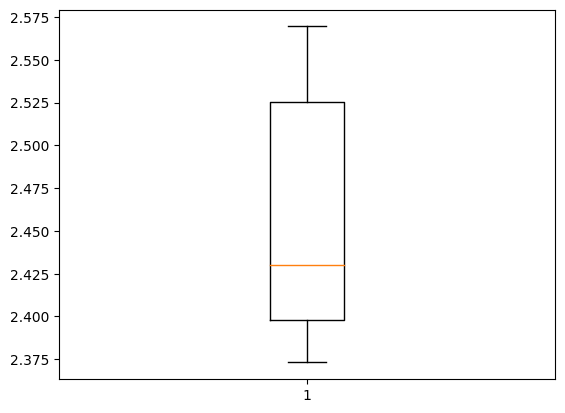

<Figure size 640x480 with 0 Axes>

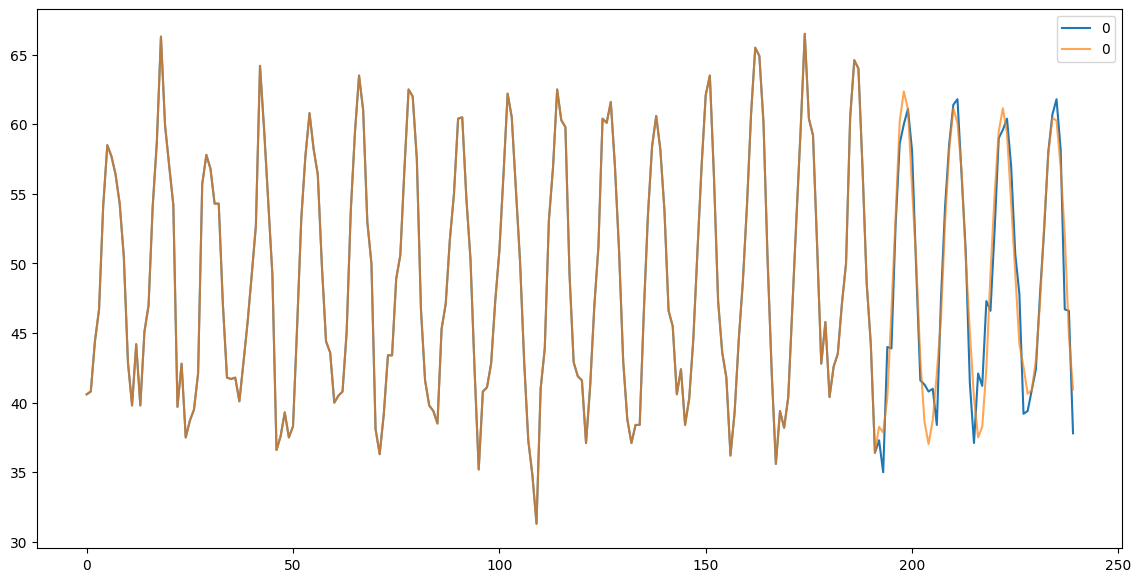

In [71]:
series_temp_nn = pd.read_csv("monthly-mean-temp.csv", header=0, index_col=0)
buscar_mejor_solucion(series_temp_nn, "monthly_temp")

In [72]:
print(long_max_temp)

192
